# Sistema evolutivo basado en reglas para clasificación

### Descripción

<font size="4"> Algoritmo evolutivo para clasificación basada en reglas.

### Componentes
    
- <font size="3"> Datos:
    
    - <font size="3"> Clasificación
 
    - <font size="3"> Entradas numéricas y categóricas
    
- <font size="3"> Algoritmo evolutivo (minimiza negative accuracy):
    
    - <font size="3"> Número de reglas fijo, enfoque Pittsburgh 
    
    - <font size="3"> Representación con parámetros reales, categóricos y binarios 

    - <font size="3"> Selección por torneo binario

    - <font size="3"> Sustitución $(\mu+\lambda)$ 

    - <font size="3"> Elitismo    

    - <font size="3"> Cruce uniforme, aritmético y SBX

    - <font size="3"> Mutación uniforme, small, polinomial y bit-flip

### Comentarios
    
- <font size="3"> Se requiere ordenar una población de $2 \cdot N$ individuos con los $\mu$ padres más los $\lambda$ hijos, $\mu=\lambda=N$.

- <font size="3"> Aunque la tarea es de clasificación y por tanto el algoritmo maximiza la accuracy, se ha decidido dejar el algoritmo evolutivo para minimización de cara a no realizar cambios en el algoritmo base presentado en el curso. De esta forma, el algoritmo minimiza la accuracy negativa: 
    $$ Minimizar \ -ACC$$    
    
---

### Requerimientos

In [1]:
import numpy as np
import heapq 
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import arff
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score

### Lectura de los datos

#### Input:
  - $file\_path$: Nombre completo con path de la base de datos .arff a cargar
  
#### Output:
- $values$: Valores
    - $X$: Atributos de entrada numéricos y categóricos:
        - $a$: Atributos de entrada numéricos
        - $b$: Atributos de entrada categóricos
    - $y$: Salida categórica   
- $bounds$: Límites
    - $LR$: Límites inferiores de los atributos de entrada numéricos
    - $UR$: Límites superiores de los atributos de entrada numéricos
    - $UC$: Límites superiores de los atributos de entrada categóricos
    - $US$: Límite superior de la salida
- $names$: Nombres
    - $Sr$: Nombres de los atributos numéricos
    - $Sc$: Nombres de los atributos categóricos
    - $S$: Nombre de la salida
    - $E$: Etiquetas de las clases de los atributos categóricos
    - $e$: Etiquetas de las clases de salida

In [2]:
def LoadData(file_path):

    data,meta = arff.loadarff(file_path)

    # Convertir a DataFrame
    df = pd.DataFrame(data)

    # Separar en entradas (a,b) y salida (y)
    df_input = df.iloc[:, :-1]              # Entradas: (a,b)
    
    class_values = meta[meta.names()[-1]][1]  # Obtiene los valores posibles de la clase 
    
    # Valores de salida
    y = [label.decode('utf-8') for label in df.iloc[:, -1]]
    le = LabelEncoder()
    le.fit(class_values)
    y = le.transform(y)
    
    # Nombres de las clases de salida
    e = class_values
    US = np.array([np.max(y)]) # Límite superior

    # Número de instancias
    w = y.size
    
    # Nombres los atributos numéricos (Sr), categóricos (Sc) y salida (S)
    Sr = df_input.select_dtypes(include=['float']).columns  
    Sc = df_input.select_dtypes(include=['object']).columns 
    S = df.columns[-1]

    # Número de attributos numéricos (n) y categóricos (m)
    n = Sr.size
    m = Sc.size

    # Atributos numéricos
    a = np.zeros((w,n), dtype=float)
    LR = np.zeros(n, dtype=float)
    UR = np.zeros(n, dtype=float)
    if (n>0):
        a = SimpleImputer(strategy='mean').fit_transform(df[Sr])  # Los datos que falten se sustituyen con la media
        a = np.array(a)
        LR = np.min(a, axis=0) # Límite inferior
        UR = np.max(a, axis=0) # Límite superior

    # Atributos categóricos
    b = np.zeros((w,m), dtype=int)
    UC = np.zeros(m, dtype=int)    
    E = []
    if (m>0):
        b = SimpleImputer(strategy='most_frequent').fit_transform(df[Sc]) # Los datos que falten se sustituyen con la moda
        index = 0
        for l in Sc:            
            class_values = meta._attributes[l].range
            le = LabelEncoder()
            le.fit(class_values)
            b_i = [label.decode('utf-8') for label in b[:,index]]
            b[:,index] = le.transform(b_i)
            index += 1
        E = [ meta._attributes[l].range for l in Sc]  # Nombres de las etiquetas de los atributos categóricos de entrada
        UC = np.max(b, axis=0) # Límite superior
        
    X = np.hstack((a, b))
    values = X,y
    
    bounds = LR,UR,UC,US
    names = Sr,Sc,S,E,e
    
    return values,bounds,names

### Parámetros del algoritmo evolutivo
- $G$: Número de generaciones
- $N$: Tamaño de la población
- $M$: Número de reglas del modelo
- $random\_state$: Semilla para reproducibilidad
- $bounds$: Límites de los datos
- $X,y$: Datos
- $prob$: Probabilidades
  - $prob\_cross$: Probabilidades de cruce
    - $p\_c$: Probabilidad de cruce
    - $uniform\_crossover\_probability$: Probabilidad de cruce uniforme
    - $arithmetic\_crossover\_probability$: Probabilidad de cruce aritmético
    - $SBX\_crossover\_probability$: Probabilidad de cruce SBX
  - $prob\_mutation$: Probabilidades de mutación
    - $p\_m$: Probabilidad de mutación
    - $uniform\_mutation\_probability$: Probabilidad de mutación uniforme 
    - $small\_mutation\_probability$: Probabilidad de mutación small 
    - $polynomial\_mutation\_probability$: Probabilidad de mutación small 
    - $epsilon$: Máximo cambio en mutación small
    - $p\_m\_binary$: Probabilidad de mutación binaria

In [ ]:
G = 100
N = 100
M = 4
random_state = 1

file_path = './DATASETS/credit-g_train.arff' # Atributos numéricos y categóricos

data = LoadData(file_path)
values,bounds,names = data
X,y = values

p_c = 0.7
uniform_crossover_probability = 0.4 
arithmetic_crossover_probability = 0.2
SBX_crossover_probability = 0.4

p_m = 0.1
uniform_mutation_probability = 0.4
small_mutation_probability = 0.2
polynomial_mutation_probability = 0.4
epsilon = 1e-6

p_m_binary                       = 0.1

prob_cross = p_c,uniform_crossover_probability,arithmetic_crossover_probability,SBX_crossover_probability
prob_mutation = p_m,uniform_mutation_probability,small_mutation_probability,polynomial_mutation_probability,epsilon,p_m_binary
prob = prob_cross,prob_mutation

### Definición del individuo

In [4]:
class Solucion:
    def __init__(self,M,n,m):
        
        # Condiciones asociadas a los atributos de entrada numéricos
        self.AL = np.zeros((M, n)) # Límites inferiores
        self.AU = np.zeros((M, n)) # Límites superiores
        self.aL = np.zeros((M, n),dtype=int) # Máscara de activación de los límites inferiores
        self.aU = np.zeros((M, n),dtype=int) # Máscara de activación de los límites superiores
        
        # Condiciones asociadas a los atributos de entrada categóricas        
        self.BB = np.zeros((M, m),dtype=int) # Valor de las condiciones asociadas a los atributos de entrada categóricos
        self.bB = np.zeros((M, m),dtype=int) # Valor de la condición
        
        # Clases de salida predichas por las reglas
        self.S = np.zeros((M,1),dtype=int)

class Individuo:
    def __init__(self,M,n,m):
        self.x = Solucion(M,n,m)
        self.f = 0.0                  
    def __lt__(self, ind):
        return self.f < ind.f

### Inicialización de la población

In [5]:
def InitializePopulation(P,bounds):
    M = P[0].x.AL.shape[0]
    LR,UR,UC,US = bounds
    n = LR.size
    m = UC.size
    for I in P:
        I.x.AL[:] = np.random.uniform(LR, UR, (M, n)) 
        I.x.AU[:] = np.random.uniform(LR, UR, (M, n)) 
        I.x.aL[:] = np.random.randint( 0,  2, (M, n)) 
        I.x.aU[:] = np.random.randint( 0,  2, (M, n))         
        I.x.BB[:] = np.random.randint( 0, UC+1, (M, m)) 
        I.x.bB[:] = np.random.randint( 0,  2, (M, m))         
        I.x.S[:]  = np.random.randint( 0, US+1, (M, 1))    

### Reparo

In [6]:
def repair(I):
    mask = I.x.AL > I.x.AU
    I.x.AL[mask], I.x.AU[mask] = I.x.AU[mask], I.x.AL[mask]

### Función de evaluación

$\textit{Maximizar} \ f(\textbf{x}) = ACC(\textbf{x},D,\Phi)$
- $\textbf{x}=\{x_1,\ldots,x_n\}$: Parámetros del modelo de reglas
- $D = (X,y)$: Dataset
- $\Phi: $ Modelo de reglas definido en $\textbf{x}$

Usa las siguientes funciones:
- $fire\_strength$: Función de disparo
    - Devuelve la fuerza de disparo del modelo para un dato
- $predict\_ind$: Función de predicción
    - Devuelve la clase predicha por el individuo (modelo) para un dato

In [7]:
def fire_strength(x,X,bounds):
    M = x.AL.shape[0]
    n = x.AL.shape[1]
    m = x.BB.shape[1]
    w = X.shape[0]
    a = X[:, :n]
    b = X[:,n:]        
    LR,UR,UC,US = bounds
    fire = np.zeros((w,M))
    for t in range(w):
        for k in range(M):
            fire[t][k] = 1.0
            # Disparo para variables numéricas
            for l in range(n):                
                if x.aL[k][l]==1 and a[t][l]<x.AL[k][l]:
                    fire[t][k] *= 1-(x.AL[k][l]-a[t][l])/(UR[l]-LR[l])
                if x.aU[k][l]==1 and a[t][l]>x.AU[k][l]: 
                    fire[t][k] *= 1-(a[t][l]-x.AU[k][l])/(UR[l]-LR[l])
            # Disparo para variables categóricas
            for l in range(m): 
                if x.bB[k][l]==1 and b[t][l]!=x.BB[k][l]:
                    fire[t][k] /= UC[l]
    return fire

def predict_ind(x,X,bounds):    
    fire = fire_strength(x,X,bounds)
    return x.S[np.argmax(fire, axis=1),0]

def evaluate(I,X,y,bounds):
    y_pred = predict_ind(I.x, X, bounds)   
    I.f = -accuracy_score(y, y_pred) # Se minimiza -f(x)

### Copia de individuo

In [8]:
def copia(I1, I2):
    np.copyto(I1.x.AL, I2.x.AL)
    np.copyto(I1.x.AU, I2.x.AU)
    np.copyto(I1.x.aL, I2.x.aL)
    np.copyto(I1.x.aU, I2.x.aU)
    np.copyto(I1.x.BB, I2.x.BB)
    np.copyto(I1.x.bB, I2.x.bB)
    np.copyto(I1.x.S, I2.x.S)
    I1.f = I2.f

### Cruce
- Se realiza el cruce con probabilidad $p\_c$
- Los parámetros numéricos se cruzan con:
    - cruce uniforme (con probabilidad $uniform\_crossover\_probability$)
    - cruce aritmético (con probabilidad $arithmetic\_crossover\_probability$)
    - cruce SBX en otro caso
- Los parámetros categóricos y binarios se cruzan con:
    - cruce uniforme

In [9]:
def uniform_crossover(x1,x2):    
    mask = np.random.rand(*x1.shape) <= 0.5    
    x1[:], x2[:] = np.where(mask,x2,x1), np.where(mask,x1,x2)
    
def arithmetic_crossover(x1,x2):
    alpha = np.random.random()
    x1[:], x2[:] = alpha*x1+(1-alpha)*x2, alpha*x2+(1-alpha)*x1
        
def SBX_crossover(x1,x2,L,U):
    eta = 10
    u = np.random.rand()
    if u <= 0.5:
        beta = (2 * u) ** (1 / (eta + 1))
    else:
        beta = (1 / (2 * (1 - u))) ** (1 / (eta + 1))    
    x1[:], x2[:] = 0.5*((1+beta)*x1+(1-beta)*x2), 0.5 *((1-beta)*x1+(1+beta)*x2)
    for k in range(x1.shape[0]):
        x1[k][:], x2[k][:] = np.clip(x1[k][:],L,U), np.clip(x2[k][:],L,U)
            
def numeric_crossover(x1,x2,uniform_crossover_probability,arithmetic_crossover_probability,L,U):
    r = np.random.random()
    if r<=uniform_crossover_probability:
        uniform_crossover(x1,x2)
    elif r<=uniform_crossover_probability+arithmetic_crossover_probability:
        arithmetic_crossover(x1,x2)
    else:
        SBX_crossover(x1,x2,L,U) 

def crossover(x1,x2,prob_cross,bounds):
    p_c,uniform_crossover_probability,arithmetic_crossover_probability,SBX_crossover_probability = prob_cross    
    LR,UR,UC,US = bounds
    if np.random.random()<=p_c:
        numeric_crossover(x1.AL,x2.AL,uniform_crossover_probability,arithmetic_crossover_probability,LR,UR)
        numeric_crossover(x1.AU,x2.AU,uniform_crossover_probability,arithmetic_crossover_probability,LR,UR)
        uniform_crossover(x1.aL,x2.aL)
        uniform_crossover(x1.aU,x2.aU)
        uniform_crossover(x1.BB,x2.BB)
        uniform_crossover(x1.bB,x2.bB)
        uniform_crossover(x1.S,x2.S)

### Mutación
- Los parámetros numéricos se mutan con probabilidad $p\_m$ y:
    - mutación uniforme numerica (con probabilidad $uniform\_mutation\_probability$)
    - mutación small (con probabilidad $small\_mutation\_probability$) 
    - mutación polinomial en otro caso
- Los parámetros categóricos se mutan con probabilidad $p\_m$ y:
    - mutación uniforme categórica
- Los parámetros binarios se mutan con probabilidad $p\_m\_binary$ y:
    - mutación bit-flip

In [10]:
def uniform_numeric_mutation(x,p_m,L,U):
    for k in range(x.shape[0]):
        for l in range(x.shape[1]):
            if np.random.random()<=p_m:
                x[k][l] = np.random.uniform(L[l],U[l])

def small_mutation(x,p_m,epsilon,L,U):
    for k in range(x.shape[0]):
        for l in range(x.shape[1]):
            if np.random.random()<=p_m:
                if np.random.random()<=0.5:
                    x[k][l] += np.random.uniform(0,epsilon)
                else:
                    x[k][l] -= np.random.uniform(0,epsilon)
    for k in range(x.shape[0]):
        x[k][:] = np.clip(x[k][:],L,U)
                
def polynomial_mutation(x,p_m,L,U):
    eta_m = 20
    for k in range(x.shape[0]):
        for l in range(x.shape[1]):
            if np.random.random()<=p_m:
                u = np.random.random()
                if u<=0.5:
                    x[k][l] += ((2*u)**(1/(1+eta_m))-1)*(x[k][l]-L[l])
                else:
                    x[k][l] += (1-(2*(1-u))**(1/(1+eta_m)))*(U[l]-x[k][l])
    for k in range(x.shape[0]):
        x[k][:] = np.clip(x[k][:],L,U)
                
def numeric_mutation(x,p_m,uniform_mutation_probability,small_mutation_probability,epsilon,L,U):
    r = np.random.random()
    if r<=uniform_mutation_probability:
        uniform_numeric_mutation(x,p_m,L,U)
    elif r<=uniform_mutation_probability+small_mutation_probability:
        small_mutation(x,p_m,epsilon,L,U)
    else:
        polynomial_mutation(x,p_m,L,U)            
            
def uniform_categorical_mutation(x,p_m,U):
    for k in range(x.shape[0]):
        for l in range(x.shape[1]):
            if np.random.random()<=p_m:
                x[k][l] = np.random.randint(U[l]+1)

def bit_flip_mutation(x,p_m_binary):
    for k in range(x.shape[0]):
        for l in range(x.shape[1]):
            if np.random.random()<=p_m:
                x[k][l] = 0 if x[k][l]==1 else 1
                
def mutation(x,prob_mutation,bounds):
    p_m,uniform_mutation_probability,small_mutation_probability,polynomial_mutation_probability,epsilon,p_m_binary = prob_mutation    
    M = x.AL.shape[0]
    n = x.AL.shape[1]
    m = x.BB.shape[1]    
    LR,UR,UC,US = bounds
    numeric_mutation(x.AL,p_m,uniform_mutation_probability,small_mutation_probability,epsilon,LR,UR)
    numeric_mutation(x.AU,p_m,uniform_mutation_probability,small_mutation_probability,epsilon,LR,UR)    
    bit_flip_mutation(x.aL,p_m_binary)
    bit_flip_mutation(x.aU,p_m_binary)           
    uniform_categorical_mutation(x.BB,p_m,UC)         
    bit_flip_mutation(x.bB,p_m_binary)           
    uniform_categorical_mutation(x.S,p_m,US)

### Selección por torneo binario

In [11]:
def binary_tournament_selection(P):
    return min(np.random.choice(P,2,replace=False))

### Progreso del algoritmo

In [12]:
def IniciaProgreso(best_individuo,G):
    best_outputs = [0]*(G+1) # Para visualizar la gráfica de evolución al final    
    progression_bar = tqdm()
    ActualizaProgreso(best_individuo,0,best_outputs,progression_bar)    
    return best_outputs,progression_bar
    
def ActualizaProgreso(best_individuo,gen,best_outputs,progression_bar):
    best_fitness = best_individuo.f
    best_acc = -best_fitness
    progression_bar.set_description("Generation: %s ACC: %s " % (str(gen), str(best_acc)))
    best_outputs[gen] = best_fitness # Añadir mejor fitness (para visualización)
    progression_bar.update(1)

### Clase que define un nuevo estimador (BaseEstimator) basado en reglas entrenado con el algoritmo evolutivo

In [13]:
class EA(BaseEstimator):
    
    def __init__(self, G, N, prob, M, bounds, random_state):

        prob_cross,prob_mutation = prob
        p_c,uniform_crossover_probability,arithmetic_crossover_probability,SBX_crossover_probability = prob_cross
        p_m,uniform_mutation_probability,small_mutation_probability,polynomial_mutation_probability,epsilon,p_m_binary = prob_mutation
        
        # Aserciones

        assert G > 0, "El número de generaciones debe ser mayor que 0."
        assert N >= 2 and not N % 2, "El tamaño de la población debe ser par y mayor que 1."  
        assert M >0, "El número de reglas debe ser mayor que 0."

        def AssertProbability(p):
            assert p>=0 and p<=1, "La probabilidad debe estar entre 0 y 1."

        AssertProbability(p_c)
        AssertProbability(uniform_crossover_probability)
        AssertProbability(arithmetic_crossover_probability)
        AssertProbability(SBX_crossover_probability)    
        assert uniform_crossover_probability + arithmetic_crossover_probability + SBX_crossover_probability == 1.0, "Error en suma de probabilidades de cruce."

        AssertProbability(p_m)
        AssertProbability(p_m_binary)    
        AssertProbability(uniform_mutation_probability)
        AssertProbability(small_mutation_probability)
        AssertProbability(polynomial_mutation_probability)
        assert uniform_mutation_probability + small_mutation_probability + polynomial_mutation_probability == 1.0, "Error en suma de probabilidades de mutación."
        
        self.G = G
        self.N = N
        self.prob = prob
        self.M = M
        self.bounds = bounds
        self.random_state = random_state
        self.best_individuo = None
        self.best_outputs = None
        
        LR,UR,UC,US = bounds
        self.n = LR.size
        self.m = UC.size
        
        
    def fit(self, X,y):
        np.random.seed(random_state)
        prob_cross,prob_mutation = self.prob

        # Crear población inicial con N individuos
        P = [Individuo(self.M,self.n,self.m) for _ in range(self.N)]
        InitializePopulation(P,self.bounds)

        # Reparar y evaluar población inicial
        for I in P:
            repair(I)
            evaluate(I,X,y,self.bounds)

        # Crear población auxilar 
        Q = [Individuo(self.M,self.n,self.m) for _ in range(2*self.N)]

        # Evoluciona durante G generaciones
        self.best_outputs, progression_bar = IniciaProgreso(min(P),self.G)    
        for gen in range(1,self.G+1):
            for i in range(self.N):
                copia(Q[i],P[i])
            i=N
            while i < 2*self.N:
                copia(Q[i],binary_tournament_selection(P))
                copia(Q[i+1],binary_tournament_selection(P))
                crossover(Q[i].x,Q[i+1].x,prob_cross,self.bounds)            
                mutation(Q[i].x,prob_mutation,self.bounds)
                mutation(Q[i+1].x,prob_mutation,self.bounds)
                repair(Q[i])
                repair(Q[i+1])                
                evaluate(Q[i],X,y,self.bounds)
                evaluate(Q[i+1],X,y,self.bounds)
                i += 2  
            R = heapq.nsmallest(N,Q)
            for i in range(self.N):
                copia(P[i],R[i])
            ActualizaProgreso(P[0],gen,self.best_outputs,progression_bar)
        self.best_individuo = P[0]
        return self
    
    def predict(self, X):    
        return predict_ind(self.best_individuo.x, X, self.bounds)   

    def score(self, X, y):
        y_pred = self.predict(X)   
        return accuracy_score(y, y_pred)

### Entrenamiento del clasificador y evaluación en el conjunto de entrenamiento

In [14]:
print("dataBase = ",file_path)
print("Generations = ",G)
print("Population = ",N)
print("M = ",M)

clasificador = EA(G,N,prob,M,bounds,random_state=random_state)
clasificador.fit(X,y)

accTrain = clasificador.score(X,y)
print("ACC train = ",accTrain)

dataBase =  ../DATASETS/credit-g_train.arff
Generations =  100
Population =  100
M =  4


Generation: 100 ACC: 0.7716666666666666 : : 101it [05:01,  2.98s/it]

ACC train =  0.7716666666666666


### Visualización de la evolución del algoritmo

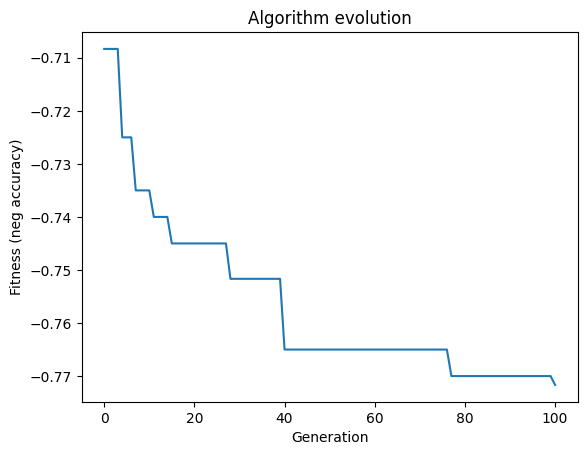

In [15]:
def VisualizaEvolucion(best_outputs):
    fig, ax = plt.subplots()
    ax.set_title("Algorithm evolution")
    plt.plot(best_outputs)
    plt.xlabel("Generation")
    plt.ylabel("Fitness (neg accuracy)")
    plt.show()
    
VisualizaEvolucion(clasificador.best_outputs)

### Imprimir el modelo basado en reglas

- Los atributos se mostrarán mediante sus nombres
- Los valores de los atributos categóricos se mostrarán mediante las etiquetas sus clases
- Los valores de la clase de salida se mostrarán mediante las etiquetas de sus clases

In [16]:
def PrintRules(x,names):
    Sr,Sc,S,E,e = names    
    M = x.AL.shape[0]
    n = x.AL.shape[1]
    m = x.BB.shape[1]    
    for k in range(M):
        print("Rule ",k+1,":")
        s = ""
        primero = True
        for l in range(n):
            if x.aL[k][l]==1 or x.aU[k][l]==1:
                if primero:
                    primero = False
                else:
                    s += " AND "                        
                if x.aL[k][l]==1 and x.aU[k][l]==1: 
                    s += str(x.AL[k][l])+" <= "+str(Sr[l])+" <= "+str(x.AU[k][l])
                if x.aL[k][l]==1 and x.aU[k][l]==0: 
                    s += str(Sr[l])+" >= "+str(x.AL[k][l])
                if x.aL[k][l]==0 and x.aU[k][l]==1: 
                    s += str(Sr[l])+" <= "+str(x.AU[k][l])
        for l in range(m):
            if x.bB[k][l]:
                if primero:
                    primero = False
                else:
                    s += " AND "            
                s += str(Sc[l])+" is "+str(E[l][x.BB[k][l]])
        if not primero:
            s = "IF "+s+" THEN "
        s += S+" is "+str(e[x.S[k][0]])
        print(s)
        
        
PrintRules(clasificador.best_individuo.x,names)

Rule  1 :
IF duration >= 8.779090925706221 AND credit_amount >= 12893.983557721569 AND installment_commitment >= 2.752837381193832 AND residence_since >= 1.16984714934947 AND existing_credits <= 2.8296467198324544 AND 1.5522743098462959 <= num_dependents <= 1.809858959839091 AND checking_status is no checking AND credit_history is delayed previously AND purpose is used car AND employment is <1 AND other_parties is none AND property_magnitude is no known property AND other_payment_plans is none AND housing is rent AND job is unemp/unskilled non res THEN class is bad
Rule  2 :
IF 22.15456912448367 <= duration <= 28.974497828347992 AND 12762.675909385729 <= credit_amount <= 14669.39908896226 AND 2.4696904511630837 <= residence_since <= 3.78175967821728 AND age <= 39.152406276867026 AND 1.2759719214764547 <= existing_credits <= 2.9427371745694915 AND checking_status is 0<=X<200 AND credit_history is no credits/all paid AND purpose is used car AND savings_status is 500<=X<1000 AND other_par

### Evaluación del clasificador en stratified k-fold cross-validation

In [17]:
n_splits=5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
resultado = cross_val_score(clasificador, X=X, y=y, scoring='accuracy',cv=cv)
print('(%d)-fold ACC = ' % n_splits, resultado)
print('(%d)-fold ACC mean (std) = %s (%s)' % (n_splits, str(resultado.mean()), str(resultado.std())))

Generation: 100 ACC: 0.76875 : : 101it [04:05,  2.43s/it]         
Generation: 100 ACC: 0.7770833333333333 : : 101it [04:08,  2.46s/it]
Generation: 100 ACC: 0.78125 : : 101it [03:58,  2.36s/it]         
Generation: 100 ACC: 0.7666666666666667 : : 101it [04:03,  2.41s/it]
Generation: 100 ACC: 0.775 : : 101it [04:02,  2.40s/it]           

(5)-fold ACC =  [0.65833333 0.73333333 0.74166667 0.70833333 0.68333333]
(5)-fold ACC mean (std) = 0.7050000000000001 (0.031001792062897122)


### Evaluación del clasificador en repeated stratified k-fold cross-validation

In [18]:
n_splits=5
n_repeats=2
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
resultado = cross_val_score(clasificador, X=X, y=y, scoring='accuracy', cv=cv)
print('(%d)-fold repeat %d - ACC mean (std) = ' % (n_splits, n_repeats), resultado)
print('(%d)-fold repeat %d - ACC mean (std) = %s (%s)' % (n_splits, n_repeats, str(resultado.mean()), str(resultado.std())))

Generation: 100 ACC: 0.76875 : : 101it [04:04,  2.42s/it]         
Generation: 100 ACC: 0.7770833333333333 : : 101it [04:05,  2.43s/it]
Generation: 100 ACC: 0.78125 : : 101it [03:53,  2.31s/it]         
Generation: 100 ACC: 0.7666666666666667 : : 101it [03:56,  2.34s/it]
Generation: 100 ACC: 0.775 : : 101it [03:59,  2.37s/it]           
Generation: 100 ACC: 0.775 : : 101it [03:58,  2.36s/it]           
Generation: 100 ACC: 0.78125 : : 101it [03:54,  2.33s/it]         
Generation: 100 ACC: 0.7854166666666667 : : 101it [03:55,  2.33s/it]
Generation: 100 ACC: 0.7729166666666667 : : 101it [04:06,  2.44s/it]
Generation: 100 ACC: 0.7791666666666667 : : 101it [03:57,  2.36s/it]

(5)-fold repeat 2 - ACC mean (std) =  [0.65833333 0.73333333 0.74166667 0.70833333 0.68333333 0.65
 0.76666667 0.69166667 0.70833333 0.73333333]
(5)-fold repeat 2 - ACC mean (std) = 0.7075 (0.03544361719689456)
